In [67]:
import sys  
sys.path.insert(1, '/home/tbron/Stuff/TensorNetworks/src')

from module import GreedyTensorNetwork
from data_module import TargetImage
from trainer import Trainer
import utils
import tensornetwork as tn
import numpy as np
import time
from PIL import Image
import matplotlib.pyplot as plt
tn.set_default_backend("pytorch")

In [68]:
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 6
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 9
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlepad'] = 20 

In [69]:
def loss(target_image, pred_image, normalized=True):
        if normalized:
            return np.linalg.norm(target_image - pred_image) / np.linalg.norm(target_image)
        else:
            return np.linalg.norm(target_image - pred_image)

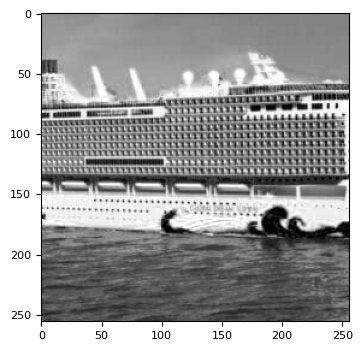

In [70]:
img_name = "cruise_ship.jpg"
target_image = TargetImage(file_name=img_name, height=256, width=256)
target_image_croped = target_image.get_matrix()
target_image.visualize()

In [71]:
max_rank = 100
err_list = []
svd_num_params = []
svd_recon_image = []

total_numel = np.prod(target_image_croped.shape)

U, S, VT = np.linalg.svd(target_image_croped, full_matrices=False)
S_diag = np.diag(S)

for r in range(1, max_rank):
    recon_mage = U[:, :r] @ S_diag[0:r, :r] @ VT[:r, :]
    svd_recon_image.append(recon_mage)
    err_list.append(loss(target_image_croped, recon_mage))
    svd_num_params.append((np.prod(U[:, :r].shape) + np.prod(VT[:r, :].shape) + np.prod(S[:r].shape)) / total_numel)

In [6]:
%%time
model = GreedyTensorNetwork(num_cores=8, core_base=4)
trainer = Trainer(max_steps=19, verbose=True, num_gpus=1)
trainer.fit(model, target_image)

Shape of the initial tensor 
 torch.Size([4, 4, 4, 4, 4, 4, 4, 4])
Run with GPU support.

----- step=0 -----
loss: 0.3169298768043518
params: 0.0006103515625
----- step=1 -----
loss: 0.30261003971099854
params: 0.00079345703125
----- step=2 -----
loss: 0.29393038153648376
params: 0.0009765625
----- step=3 -----
loss: 0.28758710622787476
params: 0.00128173828125
----- step=4 -----
loss: 0.27981871366500854
params: 0.001708984375
----- step=5 -----
loss: 0.2730729281902313
params: 0.00250244140625
----- step=6 -----
loss: 0.26629558205604553
params: 0.0032958984375
----- step=7 -----
loss: 0.2580817639827728
params: 0.0045166015625
----- step=8 -----
loss: 0.24739691615104675
params: 0.00787353515625
----- step=9 -----
loss: 0.2389335334300995
params: 0.01123046875
----- step=10 -----
loss: 0.22650019824504852
params: 0.02117919921875
----- step=11 -----
loss: 0.21522575616836548
params: 0.02789306640625
----- step=12 -----
loss: 0.20044724643230438
params: 0.0367431640625
----- step=13 

In [7]:
len(trainer.dict_res)

6

In [8]:
len(trainer.list_loss)

19

In [9]:
trainer.list_num_params[0]

0.0006103515625

In [10]:
trainer.list_loss[0].cpu()

tensor(0.3169)

In [11]:
len(trainer.list_num_params), len(svd_num_params)

(19, 99)

In [22]:
max_el = trainer.list_num_params[-1]

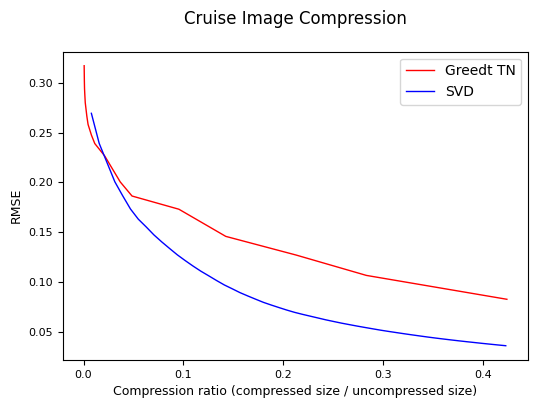

In [73]:
min_comm_el = min(trainer.list_num_params[-1], svd_num_params[-1])
greedy_tn_params_comm = [param for param in trainer.list_num_params if param <= min_comm_el]
svd_num_params_comm = [param for param in svd_num_params if param <= min_comm_el]
plt.plot(greedy_tn_params_comm, trainer.list_loss[:len(greedy_tn_params_comm)], c='r', label='Greedt TN')
plt.plot(svd_num_params_comm, err_list[:len(svd_num_params_comm)], c='b', label='SVD')
plt.title("Cruise Image Compression")
plt.xlabel("Compression ratio (compressed size / uncompressed size)")
plt.ylabel("RMSE")
plt.legend();
#plt.savefig("cruise_rmse_ratio.pdf")

In [13]:
trainer.dict_res

{'step=13, loss_val=0.18634432554244995, num_params=0.04852294921875': tensor([[0.5457, 0.5457, 0.5461,  ..., 0.5296, 0.5300, 0.5305],
         [0.5512, 0.5512, 0.5517,  ..., 0.5292, 0.5296, 0.5302],
         [0.5671, 0.5671, 0.5675,  ..., 0.5330, 0.5334, 0.5339],
         ...,
         [0.2798, 0.2798, 0.2800,  ..., 0.4093, 0.4096, 0.4100],
         [0.2653, 0.2653, 0.2655,  ..., 0.3967, 0.3970, 0.3974],
         [0.2532, 0.2532, 0.2534,  ..., 0.3858, 0.3861, 0.3865]]),
 'step=14, loss_val=0.17310358583927155, num_params=0.095458984375': tensor([[0.5609, 0.5558, 0.5378,  ..., 0.5394, 0.5219, 0.5139],
         [0.5607, 0.5580, 0.5466,  ..., 0.5369, 0.5236, 0.5174],
         [0.5648, 0.5670, 0.5690,  ..., 0.5363, 0.5315, 0.5288],
         ...,
         [0.2620, 0.2700, 0.2900,  ..., 0.3995, 0.4199, 0.4278],
         [0.2630, 0.2645, 0.2669,  ..., 0.3922, 0.4023, 0.4060],
         [0.2631, 0.2596, 0.2479,  ..., 0.3855, 0.3874, 0.3876]]),
 'step=15, loss_val=0.14588451385498047, num_param

In [31]:
lis = {10: "apple", 20: "banana", 30: "orange", 40: "grape", 50: "mango", 60: "cherry"}
indices = [2, 4, 5]
filtered_values = []

for key, value in lis.items():
    if key in indices and value:
        filtered_values.append(value)

print(filtered_values)

[]


In [63]:
trainer.list_loss[12]

tensor(0.2004)

In [35]:
trainer.dict_res

{'step=13, loss_val=0.18634432554244995, num_params=0.04852294921875': tensor([[0.5457, 0.5457, 0.5461,  ..., 0.5296, 0.5300, 0.5305],
         [0.5512, 0.5512, 0.5517,  ..., 0.5292, 0.5296, 0.5302],
         [0.5671, 0.5671, 0.5675,  ..., 0.5330, 0.5334, 0.5339],
         ...,
         [0.2798, 0.2798, 0.2800,  ..., 0.4093, 0.4096, 0.4100],
         [0.2653, 0.2653, 0.2655,  ..., 0.3967, 0.3970, 0.3974],
         [0.2532, 0.2532, 0.2534,  ..., 0.3858, 0.3861, 0.3865]]),
 'step=14, loss_val=0.17310358583927155, num_params=0.095458984375': tensor([[0.5609, 0.5558, 0.5378,  ..., 0.5394, 0.5219, 0.5139],
         [0.5607, 0.5580, 0.5466,  ..., 0.5369, 0.5236, 0.5174],
         [0.5648, 0.5670, 0.5690,  ..., 0.5363, 0.5315, 0.5288],
         ...,
         [0.2620, 0.2700, 0.2900,  ..., 0.3995, 0.4199, 0.4278],
         [0.2630, 0.2645, 0.2669,  ..., 0.3922, 0.4023, 0.4060],
         [0.2631, 0.2596, 0.2479,  ..., 0.3855, 0.3874, 0.3876]]),
 'step=15, loss_val=0.14588451385498047, num_param

In [54]:
plt.rcParams['figure.figsize'] = (15, 8)

In [1]:
dict_size = len(trainer.dict_res)
sample_descs = ['step=13, loss_val=0.18634432554244995, num_params=0.04852294921875',
                'step=14, loss_val=0.17310358583927155, num_params=0.095458984375',
                'step=15, loss_val=0.14588451385498047, num_params=0.14239501953125',
                'step=16, loss_val=0.1271938532590866, num_params=0.2127685546875']
sample_indices = [0, 1, 2, 3]

sample_tn_recon_image = [trainer.dict_res[desc] for desc in sample_descs]
sample_tn_num_params = [trainer.list_num_params[13:][ind] for ind in sample_indices]

rows = 1
columns = len(sample_indices) + 1
compr_ratios_perc = [round(ratio * 100, 2) for ratio in sample_tn_num_params]
fig, ax_array = plt.subplots(rows, columns, squeeze=False, gridspec_kw = {'wspace':0, 'hspace':0})
for i, ax_row in enumerate(ax_array):
    for j, axes in enumerate(ax_row):
        axes.set_yticklabels([])
        axes.set_xticklabels([])
        #axes.plot(you_data_goes_here,'r-')
        if j == 0:
            axes.imshow(target_image.get_matrix(), cmap='gray')
            axes.set_title('Original')
        else:
            axes.imshow(sample_tn_recon_image[j - 1], cmap='gray')
            axes.set_title(f'$C={compr_ratios_perc[j - 1]}$%')
plt.subplots_adjust(wspace = 0, hspace = 0)
fig.supylabel('Greedy-TN', fontsize=10)
plt.savefig("cruise_ship_tn.png", bbox_inches = 'tight')
plt.show()

NameError: name 'trainer' is not defined

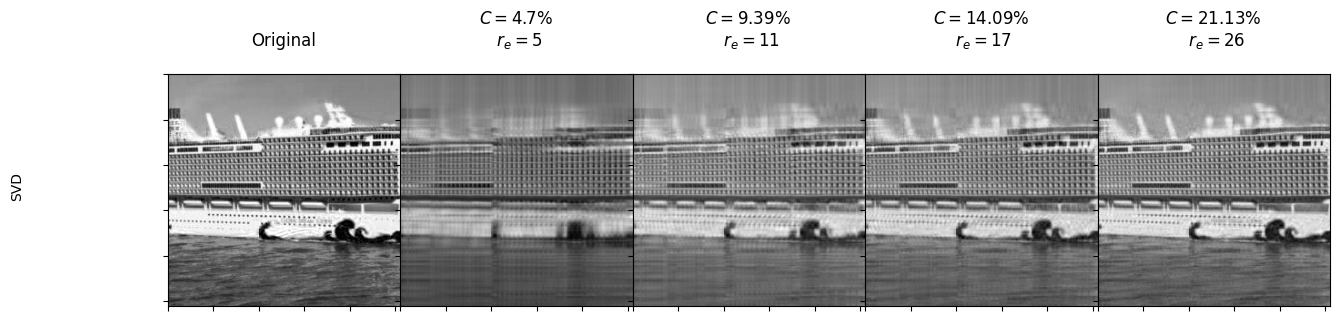

In [66]:
sample_ranks = [5, 11, 17, 26]
sample_svd_recon_image = [svd_recon_image[r] for r in sample_ranks]
sample_svd_num_params = [svd_num_params[r] for r in sample_ranks]
rows = 1
columns =  len(sample_svd_recon_image) + 1
compr_ratios_perc = [round(ratio * 100, 2) for ratio in sample_svd_num_params]
fig, ax_array = plt.subplots(rows, columns, squeeze=False, gridspec_kw = {'wspace':0, 'hspace':0})
for i, ax_row in enumerate(ax_array):
    for j, axes in enumerate(ax_row):
        axes.set_yticklabels([])
        axes.set_xticklabels([])
        #axes.plot(you_data_goes_here,'r-')
        if j == 0:
            axes.imshow(target_image.get_matrix(), cmap='gray')
            axes.set_title('Original')
        else:
            axes.imshow(sample_svd_recon_image[j - 1], cmap='gray')
            axes.set_title('$C={}$% \n $r_e = {}$'.format(compr_ratios_perc[j - 1], sample_ranks[j - 1]))
            #axes.set_title(f'$C={compr_ratios_perc[i + j - 1]}$ \n $r_e = {sample_ranks[i + j - 1]}$', wrap=True)
plt.subplots_adjust(wspace = 0, hspace = 0)
fig.supylabel('SVD', fontsize=10)
#plt.savefig("cruise_ship_svd.png", bbox_inches = 'tight')
plt.show()